In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [3]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 65.92%
Test  size ≃ 34.08%


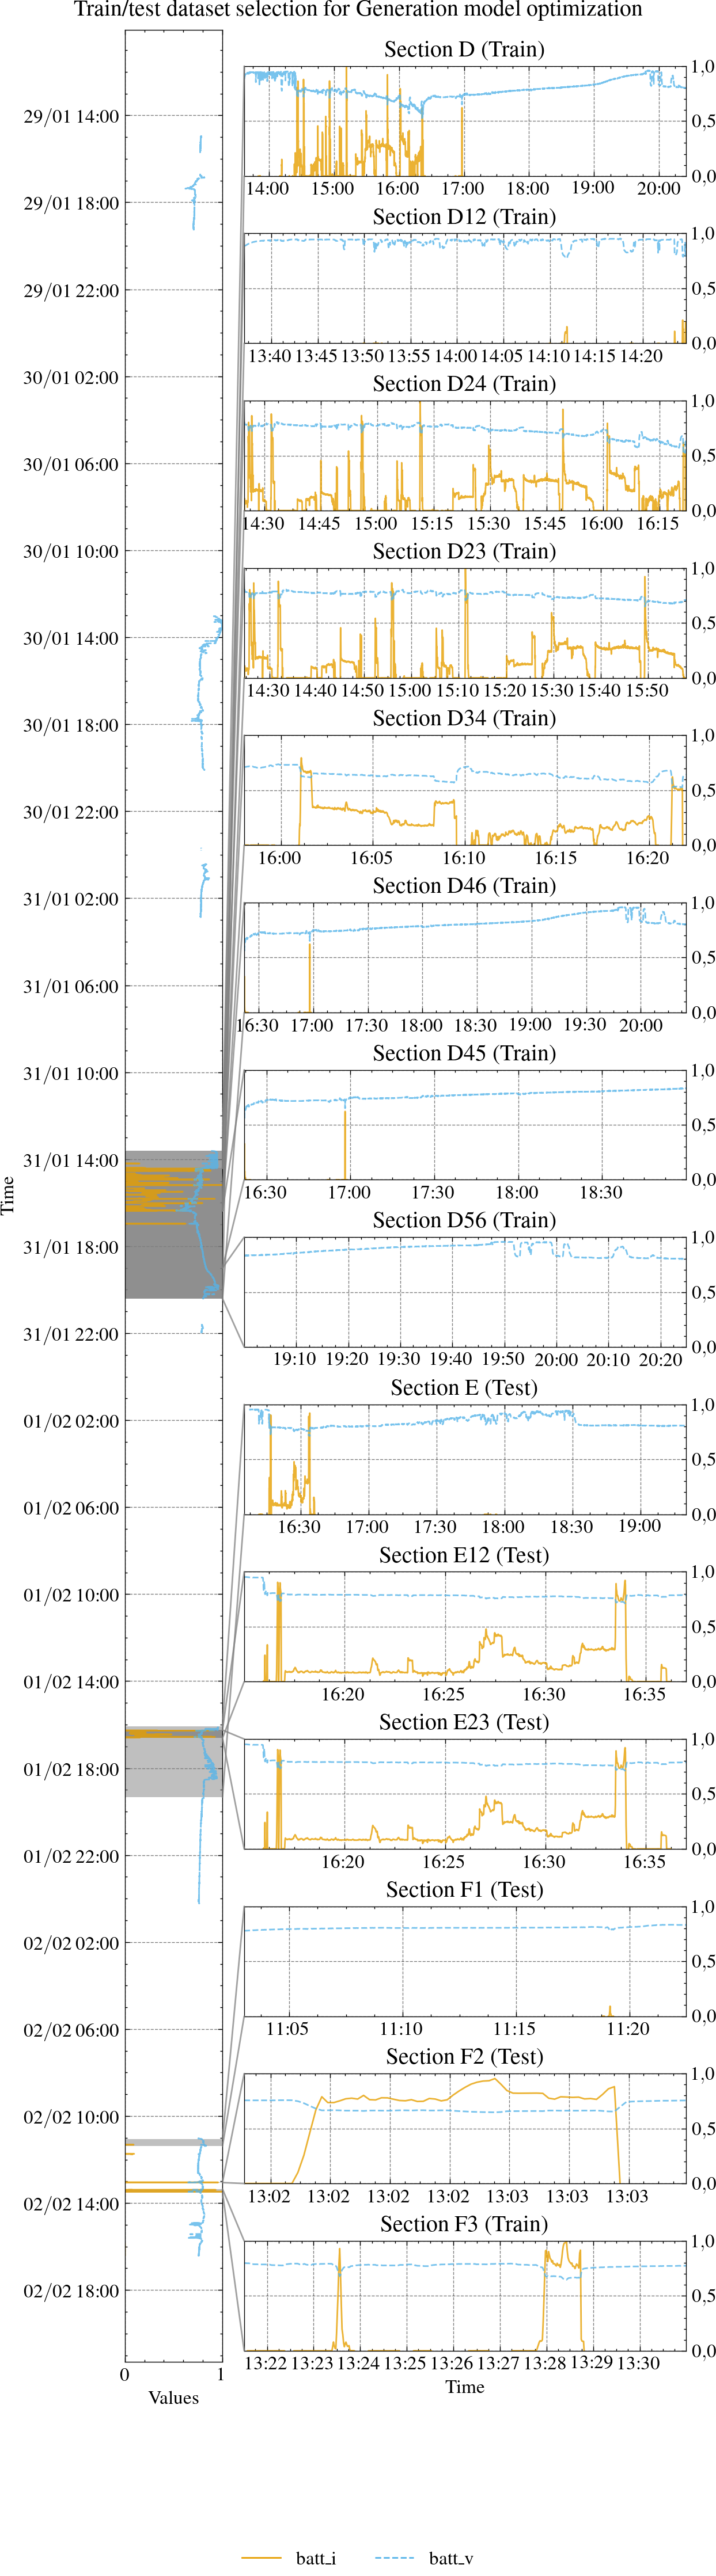

In [4]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp('2020-01-31 13:37:04')  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp('2020-01-31 14:24:40')  # start of the race
D3 = pd.Timestamp('2020-01-31 15:58:00')  # battery enters in deep-discharge
D4 = pd.Timestamp('2020-01-31 16:22:00')  # race finishes, post-race charge starts
D5 = pd.Timestamp('2020-01-31 19:00:00')  # overcharge starts
D6 = pd.Timestamp('2020-01-31 20:24:55')  # end of the day
sections.loc['Section D'] = [D1, D6]  # Full race event
sections.loc['Section D12'] = [D1, D2]  # Full pre-race charge
sections.loc['Section D24'] = [D2, D4]  # Full race discharge
sections.loc['Section D23'] = [D2, D3]  # Race normal discharge range
sections.loc['Section D34'] = [D3, D4]  # Race deep-discharge range
sections.loc['Section D46'] = [D4, D6]  # Full post-race charge
sections.loc['Section D45'] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc['Section D56'] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc['Section E'] = [pd.Timestamp('2020-02-01 16:05:00'), pd.Timestamp('2020-02-01 19:20:00')] # A quick 15min discharge followed by an overcharge
sections.loc['Section E12'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # A ~15min discharge
sections.loc['Section E23'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # Another over-charging section
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 11:03:00'), pd.Timestamp('2020-02-02 11:22:30')] # A quick charge section
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:02:15'), pd.Timestamp('2020-02-02 13:03:30')] # 2min high-current pulse
sections.loc['Section F3'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:31:00')] # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section E', 'Section E12', 'Section E23', 'Section F1', 'Section F2', 'Section F3']]

train_sections_names = ['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section F3']

train_test_sections = sections.reset_index().to_dict(orient='records')
train_sections = sections.loc[sections.index.intersection(train_sections_names)].reset_index().to_dict(orient='records')
test_sections = sections.loc[sections.index.difference(train_sections_names)].reset_index().to_dict(orient='records')
all_sections = sections.reset_index().to_dict(orient='records')

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask  = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        sec['name'] = sec['name'] + ' (Train)'
        train_mask |= mask
    else:
        sec['name'] = sec['name'] + ' (Test)'
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test  size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Battery Equivalent Circuit Model


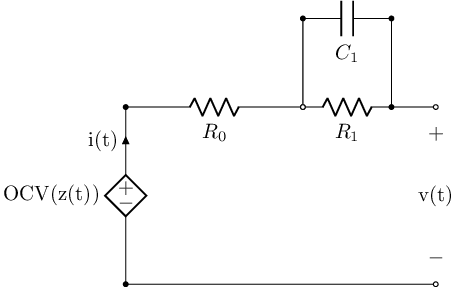

In [5]:
# %pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png")


![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &= 
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [ ]:
import numpy as np
import control as ct


def eval_poly(coeffs, x):
    result = 0.0
    for c in reversed(coeffs[1:]):
        result = (result + c) * x
    return result + coeffs[0]


class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_0 = params['batt_R_0']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_N_S = params['batt_N_S']

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']
        batt_v_0 = X0['batt_v']

        # Inputs
        batt_i_0 = U0[0]  # Battery current [A]

        # Initial condition equations
        batt_ocv_0 = eval_poly(batt_k_V_OC_coeffs, batt_z_0)

        # v_C1_0 = v_C2_0 = v_C_0 so that terminal voltage matches batt_v_0
        # batt_v_0 / batt_N_S = batt_ocv_0 - 2*v_C_0 - batt_R_0 * batt_i_0
        v_C_0 = (batt_ocv_0 - batt_R_0 * batt_i_0 - batt_v_0 / batt_N_S) / 2.0

        batt_v_C_1_0 = v_C_0
        batt_v_C_2_0 = v_C_0

        return np.array([batt_z_0, batt_v_C_1_0, batt_v_C_2_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta = params['batt_eta']
        batt_Q = params['batt_Q']
        batt_R_1 = params['batt_R_1']
        batt_C_1 = params['batt_C_1']
        batt_R_2 = params['batt_R_2']
        batt_C_2 = params['batt_C_2']

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        # batt_z = x[0]
        batt_v_C_1 = x[1]
        batt_v_C_2 = x[2]

        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = -(batt_v_C_1 / (batt_R_1 * batt_C_1)) + (batt_i / batt_C_1)
        d_batt_v_C_2 = -(batt_v_C_2 / (batt_R_2 * batt_C_2)) + (batt_i / batt_C_2)

        return np.array([d_batt_z, d_batt_v_C_1, d_batt_v_C_2])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_N_S = params['batt_N_S']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_R_0 = params['batt_R_0']

        # Inputs
        batt_i = u[0]

        # States
        batt_z = x[0]
        batt_v_C_1 = x[1]
        batt_v_C_2 = x[2]

        batt_ocv = eval_poly(batt_k_V_OC_coeffs, batt_z)
        batt_v = batt_N_S * (batt_ocv - batt_v_C_1 - batt_v_C_2 - batt_R_0 * batt_i)

        return np.array([batt_v, batt_z, batt_ocv])

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'batt_v_C_1', 'batt_v_C_2'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem battery: ['batt_i'] -> ['batt_v', 'batt_z', 'batt_ocv']>

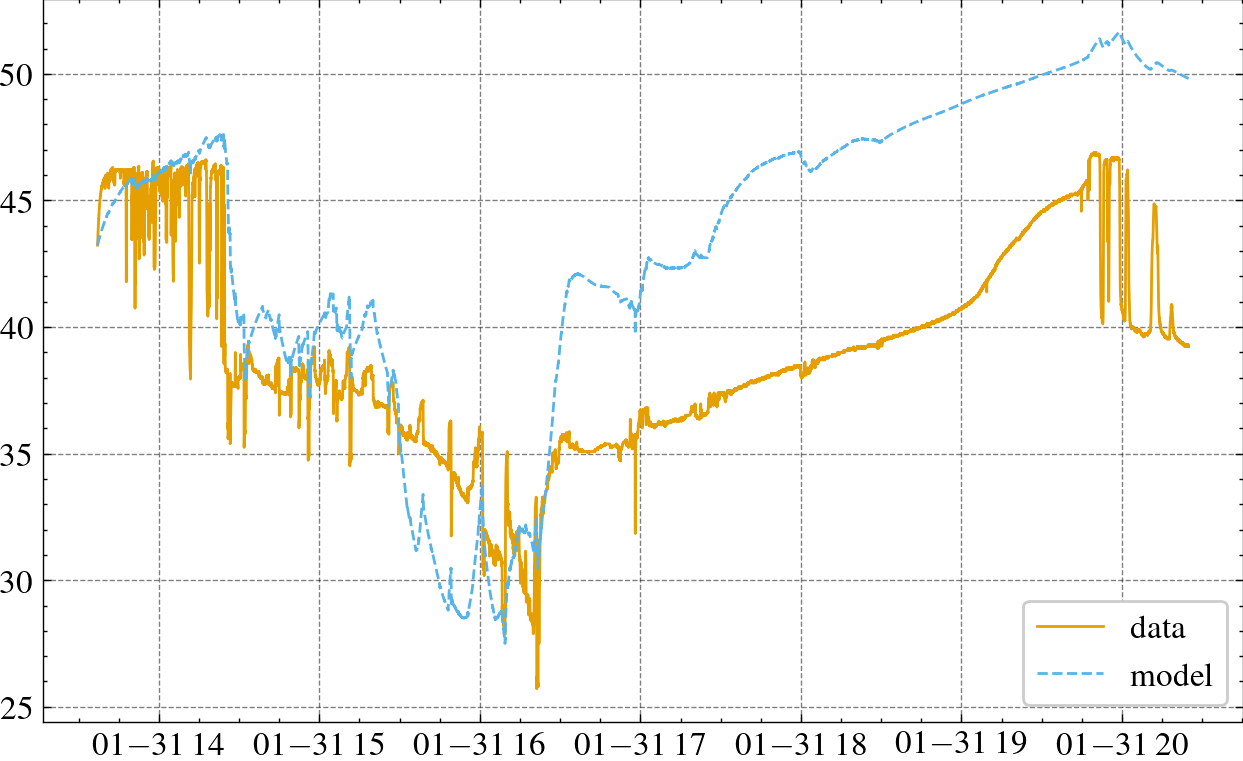

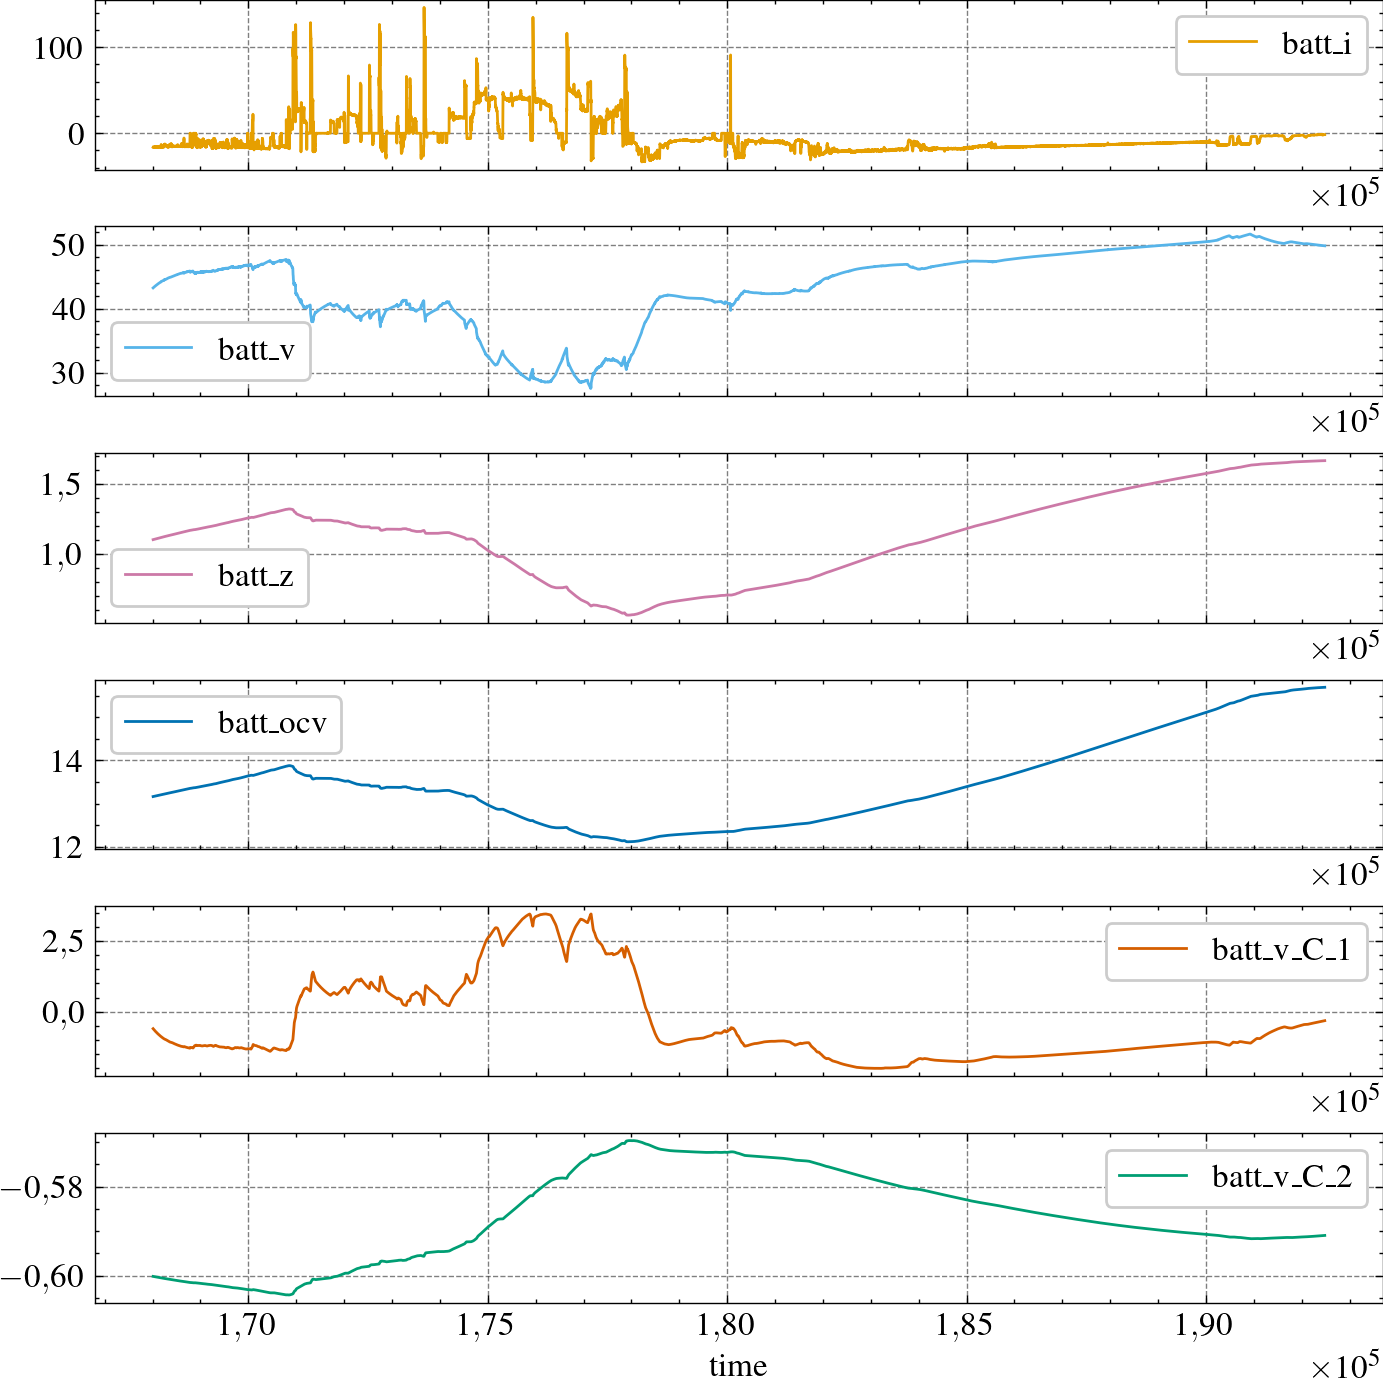

In [ ]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1.1
nominal_voltage = series_cells * cell_voltage
batt_k_V_OC_coeffs = np.array([10.7864583333, 3.5863893517, -3.0753011401, 1.6163721814])

battery_params = {
    'batt_N_S': series_cells,
    'batt_Q': cell_amps_hour * 3600,
    'batt_eta': 1,

    'batt_R_0': 3e-3,
    'batt_R_1': 10e-2,
    'batt_C_1': 5e3,
    'batt_R_2': 10e-2,
    'batt_C_2': 5e6,

    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
}

if True:
    # Select the optimization data
    data_cols = ['batt_v']
    input_cols = ['batt_i']
    train_section = train_sections[0]

    df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]#[:7000]

    # Time array
    T = np.ascontiguousarray(df_train['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_train[['batt_i']].to_numpy().T)

    # Model
    battery = Battery.build(battery_params)

    # Initial state
    X0 = Battery.initial_state(
        X0 = {
            "batt_z": initial_SOC,              # dimensionless SOC in [0, 1]
            "batt_v": float(df_train["batt_v"].iloc[0]),  # initial PACK voltage [V]
        },
        U0=U[:,0],
        params=battery_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau', solve_ivp_kwargs=dict(max_step=1))
    ydata = res.to_pandas().set_index('time')#[sorted(list(set(res.output_labels + res.state_labels)))]

    plt.figure()
    plt.plot(df_train.index, df_train['batt_v'], label='data')
    plt.plot(df_train.index, ydata['batt_v'], label='model')
    plt.legend(loc='lower right')
    plt.show()

    ydata.plot(subplots=True, figsize=(7,7))
    plt.show()

# Optimization

In [8]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

# Constraints
from dataclasses import dataclass
from typing import Literal
import numpy as np

ConstraintKind = Literal[
    "simple_order",
    "simple_gap",
    "deep_extra",
    "beta_z_min",
    "beta_z_max",
    "smoothness",
]

@dataclass
class ParamConstraint:
    """
    Generic constraint usable by pymoo: g(x) <= 0 when satisfied.
    Picklable, works with multiprocessing.
    """
    kind: ConstraintKind

    # indices into the decision vector x
    idx_a: int | None = None
    idx_b: int | None = None
    idx_c: int | None = None  # third index if needed (e.g. z_deep)

    # generic scalars for constraints
    gap: float = 1.0          # used by simple_gap
    limit: float = 0.0        # used by deep_extra, beta_z_min/max

    def __call__(self, x: np.ndarray) -> float:
        if self.kind == "simple_gap":
            # tau_b >= gap * tau_a -> gap*tau_a - tau_b <= 0
            return self.gap * x[self.idx_a] - x[self.idx_b]

        if self.kind == "simple_order":
            # R_a < R_b -> R_a - R_b <= 0
            return x[self.idx_a] - x[self.idx_b]

        if self.kind == "deep_extra":
            # deep-discharge extra "ohms" at z ~ 0:
            #   R_extra = R0_deep + k_deep * max(0, z_deep)
            # constraint: R_extra <= limit  -> R_extra - limit <= 0
            R0_deep = x[self.idx_a]
            k_deep  = x[self.idx_b]
            z_deep  = x[self.idx_c]
            R_extra = R0_deep + k_deep * max(0.0, z_deep)
            return R_extra - self.limit

        if self.kind == "beta_z_min":
            # beta * z_deep >= limit  -> limit - beta*z <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return self.limit - beta * z_deep

        if self.kind == "beta_z_max":
            # beta * z_deep <= limit  -> beta*z - limit <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return beta * z_deep - self.limit
        
        if self.kind == "smoothness":
            return abs(x[self.idx_a] - 2*x[self.idx_b] + x[self.idx_c]) - self.limit

        return 0.0

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  0.000000E+00 |  0.0001652027 |  0.2795823376 |  0.0028941336
     2 |      200 |  0.000000E+00 |  0.0000523165 |  0.2094669142 |  0.0028941336
     3 |      300 |  0.000000E+00 |  0.000000E+00 |  0.1242249143 |  0.0022217114
     4 |      400 |  0.000000E+00 |  0.000000E+00 |  0.0636350780 |  0.0022217114
     5 |      500 |  0.000000E+00 |  0.000000E+00 |  0.0322830572 |  0.0022217114
     6 |      600 |  0.000000E+00 |  0.000000E+00 |  0.0173823492 |  0.0022217114
     7 |      700 |  0.000000E+00 |  0.000000E+00 |  0.0131616785 |  0.0017796788
     8 |      800 |  0.000000E+00 |  0.000000E+00 |  0.0080711792 |  0.0017796788
     9 |      900 |  0.000000E+00 |  0.000000E+00 |  0.0067631196 |  0.0017796788
    10 |     1000 |  0.000000E+00 |  0.000000E+00 |  0.0061682161 |  0.0017796788
    11 |     1100 |  0.000000E+00 |  0.000000E+00 |  0.0035177013 |  0.0017796788
    12 |     120

{'batt_R_0': 0.003,
 'batt_R_1': 0.1,
 'batt_R_2': 0.1,
 'batt_C_1': 5000.0,
 'batt_C_2': 5000000.0}

Best parameters found:


{'batt_R_0': 0.0046351552806151025,
 'batt_R_1': 0.005567185408885957,
 'batt_R_2': 0.022681056911324566,
 'batt_C_1': 374.0952049310755,
 'batt_C_2': 107967.56094014487}

Objective value at solution: [0.00161456]


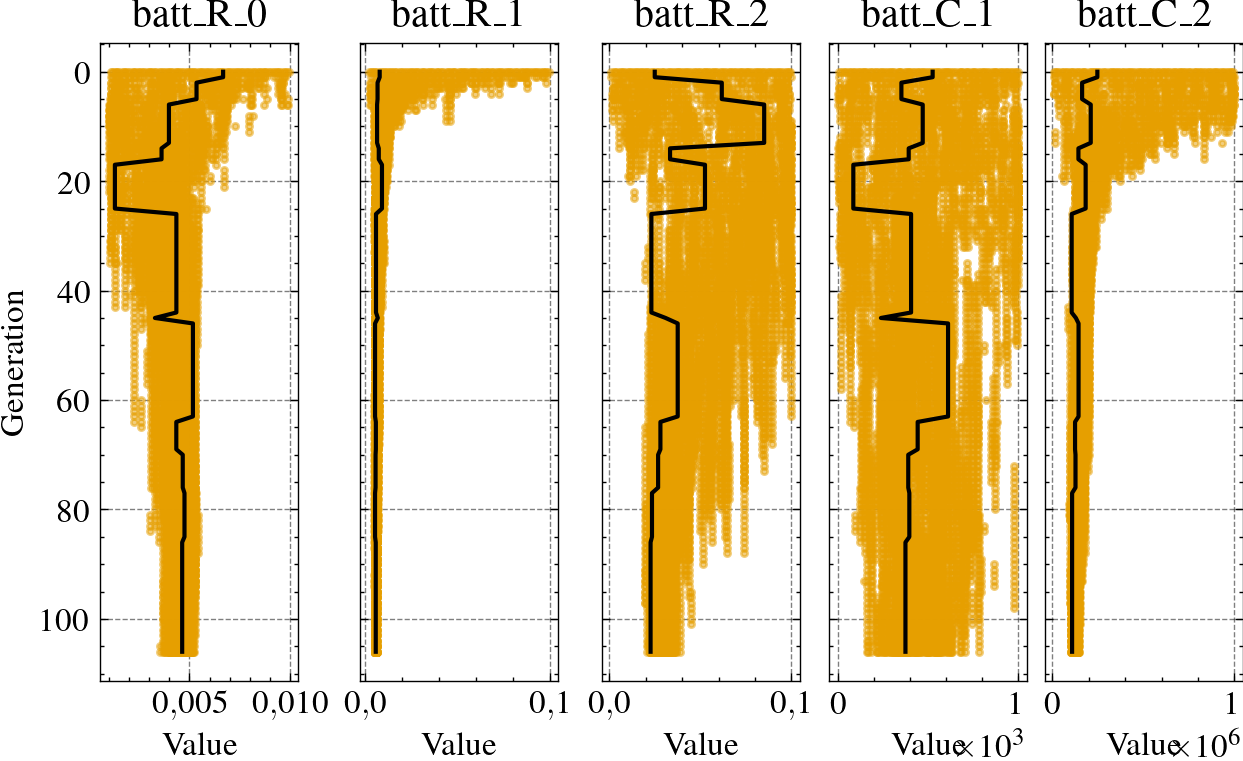

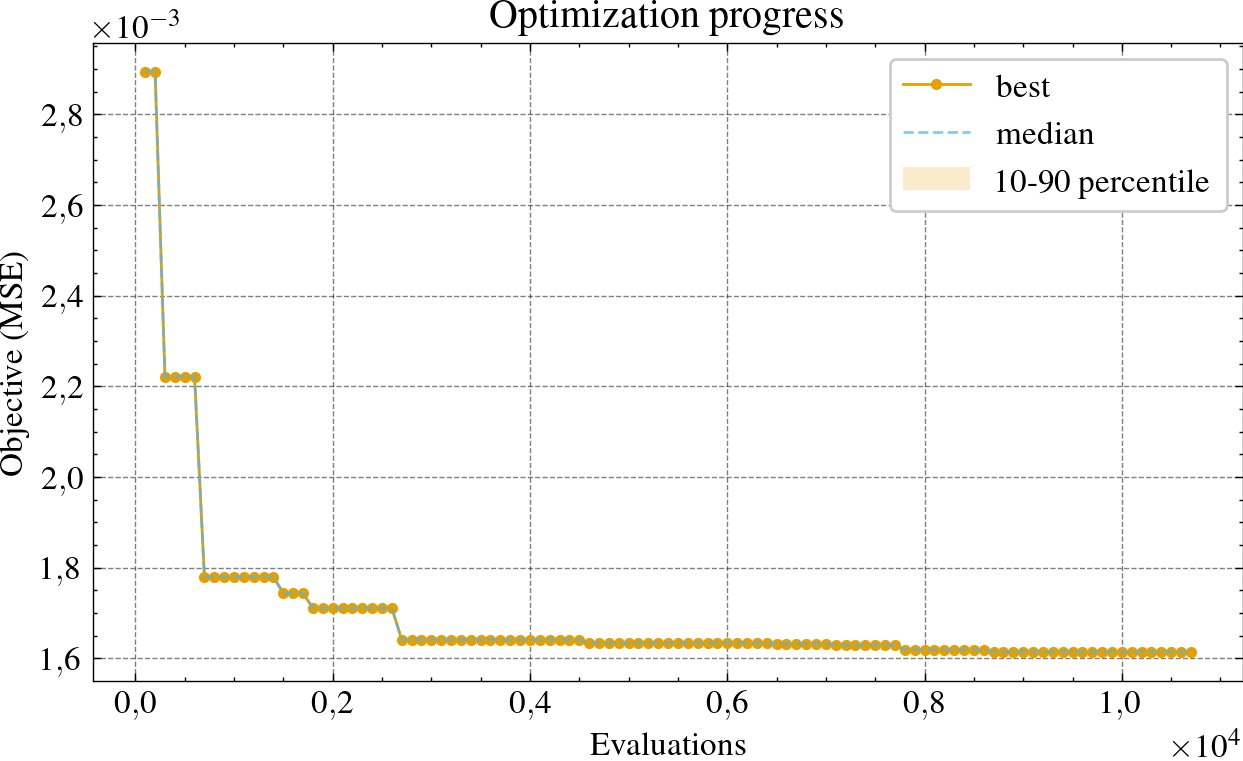

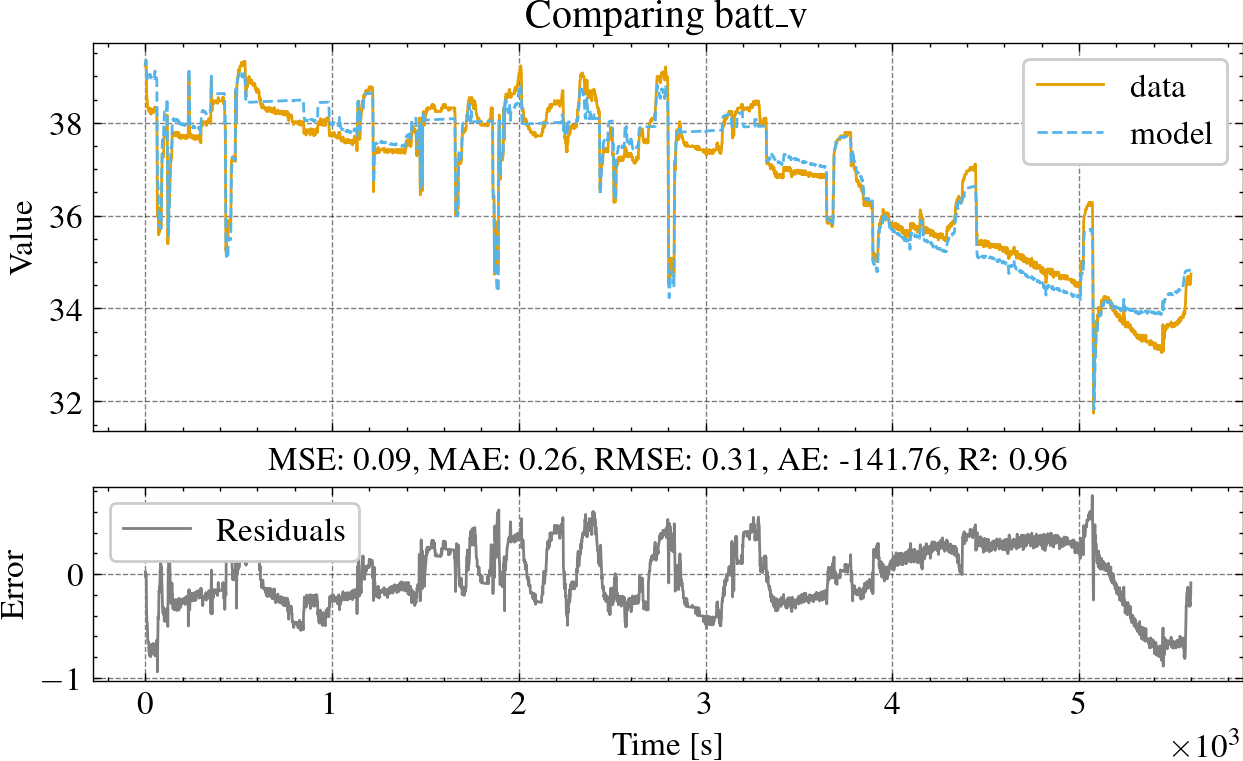

CPU times: user 7.48 s, sys: 2.81 s, total: 10.3 s
Wall time: 5min 55s


In [ ]:
%%time

def build_ECM_constraints(params_bounds: dict) -> list[ParamConstraint]:
    names = list(params_bounds.keys())
    idx = {name: i for i, name in enumerate(names)}

    cons: list[ParamConstraint] = []

    # OCV monotonic LUT constraint (monotone increasing in z) ---
    # if 'batt_k_V_OC_coeffs_0' in params_bounds:
    #     ocv_names = sorted( # collect OCV parameters in SoC order
    #         [n for n in names if n.startswith("batt_k_V_OC_coeffs_")],
    #         key=lambda s: int(s.split("_")[-1])
    #     )
    #     for a_name, b_name in zip(ocv_names[:-1], ocv_names[1:]):
    #         cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
    #     for i in range(1, len(ocv_names) - 1):
    #         cons.append(ParamConstraint(kind="smoothness", idx_a=idx[ocv_names[i-1]], idx_b=idx[ocv_names[i]], idx_c=idx[ocv_names[i+1]], limit=eps))

    cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_R_0'], idx_b=idx['batt_R_1']))  # R0 < R2
    cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_R_0'], idx_b=idx['batt_R_2']))  # R0 < R2
    cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_C_1'], idx_b=idx['batt_C_2']))  # C1 < C2

    return cons

def run_battery_optimization(
    df,
    train_section,
    nominal_Q,
    model,
    model_params,
    model_function,
    initial_SOC
):
    # Define optimization and input data columns
    data_cols = ['batt_v']
    input_cols = ['batt_i']

    # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ]#.resample('1s').mean().interpolate(method='time')

    # Compute battery capacity and SOC using the hyperparameter initial_SOC
    compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_train, nominal_Q, inplace=True)
    # df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

    # Set model state initial conditions
    input_initial_state = {
        'batt_z': df_train['batt_z'].iloc[0],
        'batt_v': df_train['batt_v'].iloc[0],
    }

    # Initialize parameter bounds for the optimization
    params_bounds = {
        'batt_R_0': dict(min=1e-3, max=1e-2),
        'batt_R_1': dict(min=1e-3, max=1e-1),
        'batt_R_2': dict(min=1e-3, max=1e-1),
        'batt_C_1': dict(min=1, max=1e3),
        'batt_C_2': dict(min=1e2, max=1e6),
    }
    poly_coeffs = [
        # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1), 'y_bounds': (0.5*10.5, 2*13.5)},
    ]
    for coeff in poly_coeffs:
        name = coeff['name']
        n_coeffs = coeff['n_coeffs']
        y_bounds = coeff['y_bounds']
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
        )
        for i in range(n_coeffs):
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    try:

        # Set up the optimization problem
        problem = MyOptimizationProblem(
            model=model,
            model_function=model_function,
            training_data=df_train,
            training_data_columns=data_cols,
            model_params=model_params,
            opt_params_bounds=params_bounds,
            input_initial_state=input_initial_state,
            input_columns=input_cols,
            data_scaler=MinMaxScaler,
            constraint_funcs=build_ECM_constraints(params_bounds),
            elementwise_runner=runner,
        )

        # Configure the optimization algorithm (Differential Evolution in this case)
        algorithm = DE(
            pop_size=20 * len(params_bounds),
            sampling=LHS(),
            variant="DE/rand/1/bin",
            F=0.5,
            CR=0.9,
        )

        # Set termination criteria
        termination = DefaultSingleObjectiveTermination(
            xtol=1e-8,
            cvtol=1e-6,
            ftol=1e-6,
            period=20,
            n_max_gen=10000,
            n_max_evals=100000,
        )

        # Run the optimization
        result = minimize(
            problem,
            algorithm,
            termination=termination,
            seed=42,
            verbose=True,
            save_history=True,
        )
    finally:
        pool.close()
        pool.join()

    return result, params_bounds

train_section_name = 'Section D23'
train_section = next(s for s in train_sections if s['name'] == train_section_name)

model = Battery
model_params = battery_params.copy()
result, params_bounds = run_battery_optimization(
    df=df,
    train_section=train_section,
    nominal_Q=nominal_Q,
    model=model,
    model_params=model_params,
    model_function=model_function,
    initial_SOC=initial_SOC,
)

# Retrieve and display the best parameters
best_params = convert_to_model_params({k: result.X[i] for i, k in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

# Plot optimization results
plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

# Simulate the model with the optimized parameters
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = Battery.initial_state(
    X0={
        'batt_z': initial_SOC,
        'batt_v': float(df_train['batt_v'].iloc[0])
    },
    U0=U[:, 0],
    params=model_params | best_params
)
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# Plot the comparison for each data column
for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

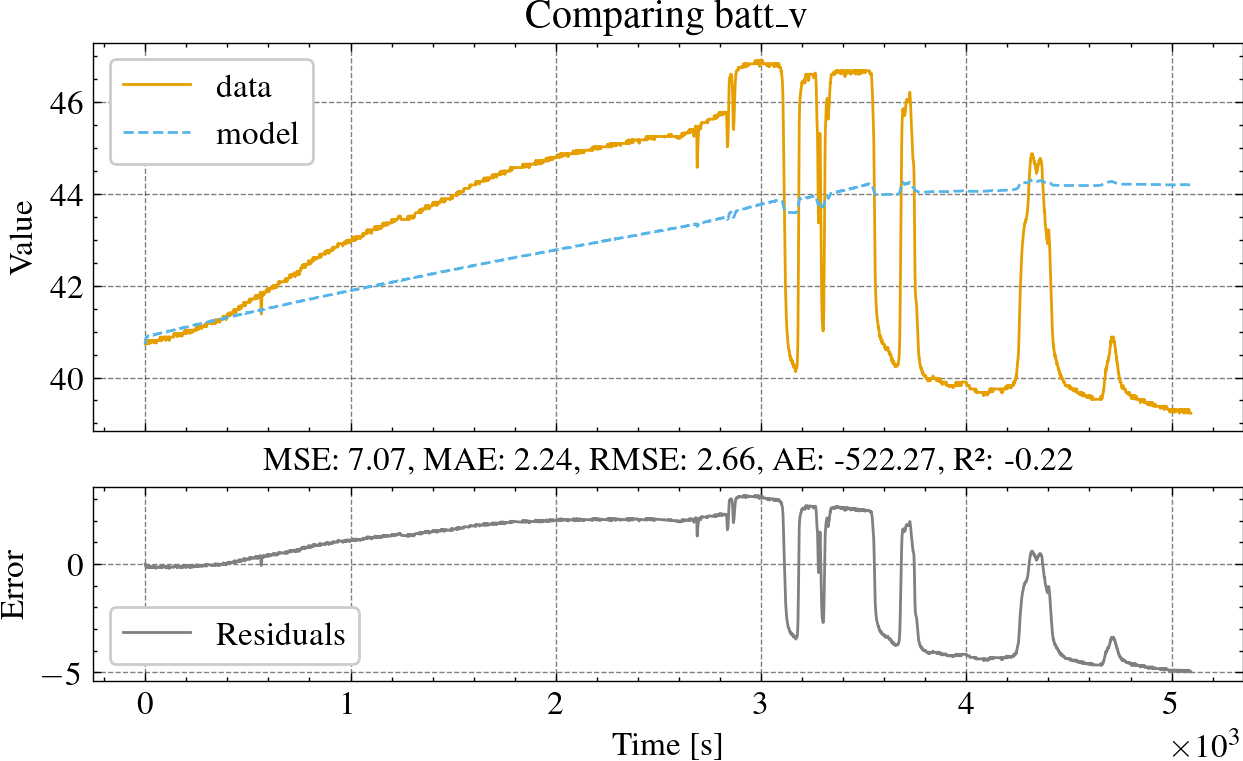

In [ ]:
# initial_SOC = 1.2
# train_section_name = 'Section D56'
# train_section = next(s for s in train_sections if s['name'] == train_section_name)

# model = Battery
# model_params = battery_params.copy()

# df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
# T = np.ascontiguousarray(df_train['t'].to_numpy())
# U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
# X0 = Battery.initial_state(
#     X0={
#         'batt_z': initial_SOC,
#         'batt_v': float(df_train['batt_v'].iloc[0])
#     },
#     U0=U[:, 0],
#     params=model_params | best_params
# )
# best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# # Plot the comparison for each data column
# for col in data_cols:
#     plot_compare(df_train, best_fit_data, col)

In [ ]:
%%time

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, best_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, xl=np.array([0.0]), xu=np.array([1.0]), type_var=Real, **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.best_params = best_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols
        ].copy().resample('1s').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = np.ascontiguousarray(df_test['t'].to_numpy())
        U = np.ascontiguousarray(df_test[self.input_cols].to_numpy().T)

        X0 = Battery.initial_state(
            X0={
                'batt_z': df_test['batt_z'][0],
                'batt_v': df_test['batt_v'][0],
            },
            U0=U[:, 0],
            params=self.model_params | self.best_params
        )

        try:
            if not np.all(np.isfinite(X0)):
                raise ValueError(f"Non-finite X0 in model_function: {X0!r}")

            df_pred = model_function(T, U, X0, **(self.model_params | self.best_params))
        except Exception as e:
            print(f"[{self.section['name']}] model_function failed: {e}")
            out["F"] = 1e9
        return

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

model_params = battery_params.copy()
try:
    # Run optimization for each section
    batt_z_0_dict = {}
    for section in sections.reset_index().to_dict(orient='records'):
        section_name = section['name'].replace('Section ', '')

        problem = BattZOptimization(
            section, df, nominal_Q, model_params, best_params, data_cols, input_cols, elementwise_runner=runner,
        )

        algorithm = DE(
            pop_size=10,
            sampling=LHS(),
            variant="DE/rand/1/bin",
            F=0.5,
            CR=0.9,
        )

        termination = DefaultSingleObjectiveTermination(
            xtol=1e-8,
            cvtol=1e-6,
            ftol=1e-6,
            period=10,
            n_max_gen=10000,
            n_max_evals=100000
        )

        res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

        batt_z_0_dict[section_name] = res.X[0]

        print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')
finally:
    pool.close()
    pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

{'D': 0.8617620802256827, 'D12': 0.9999721957708123, 'D24': 0.8665425590770706, 'D23': 0.9991991667781953, 'D34': 0.03287374406308846, 'D46': 0.2971564971907275, 'D45': 0.2308968343645026, 'D56': 0.9999995328626179}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d.pdf


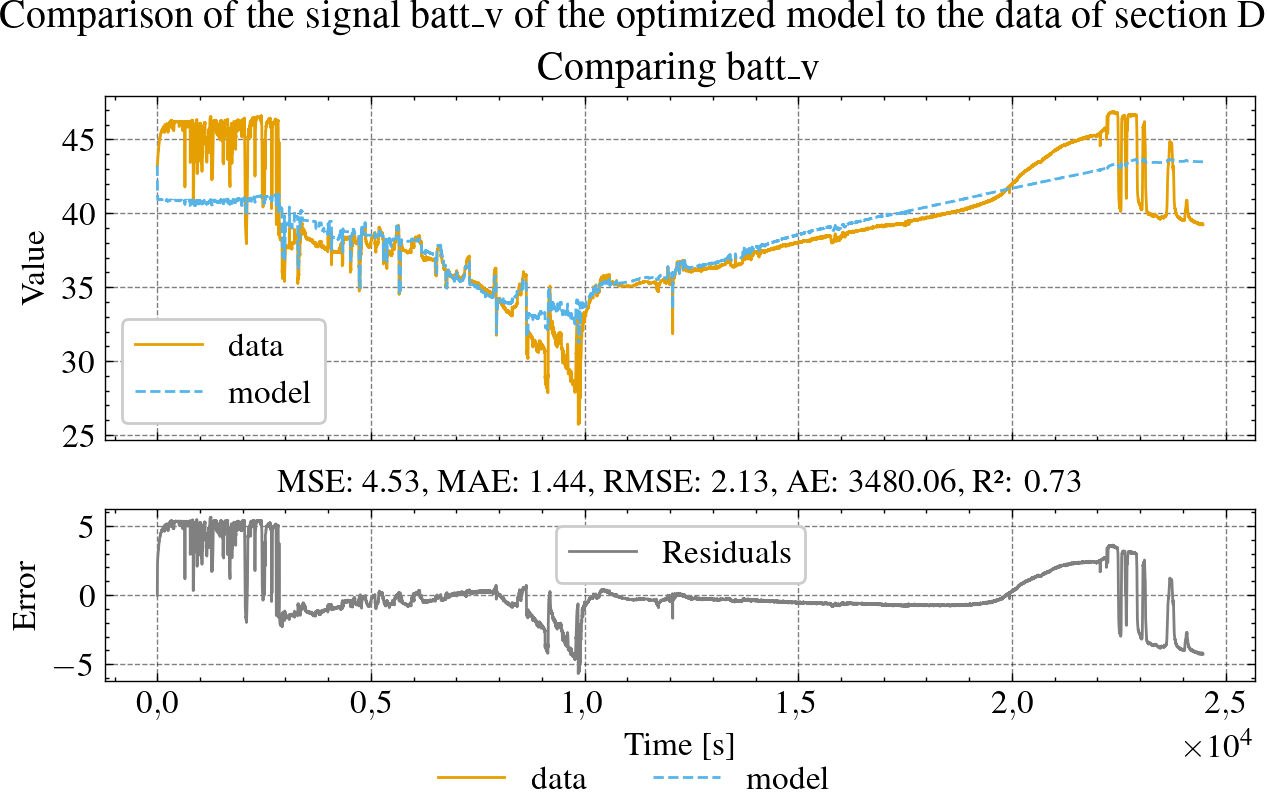

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d12.pdf


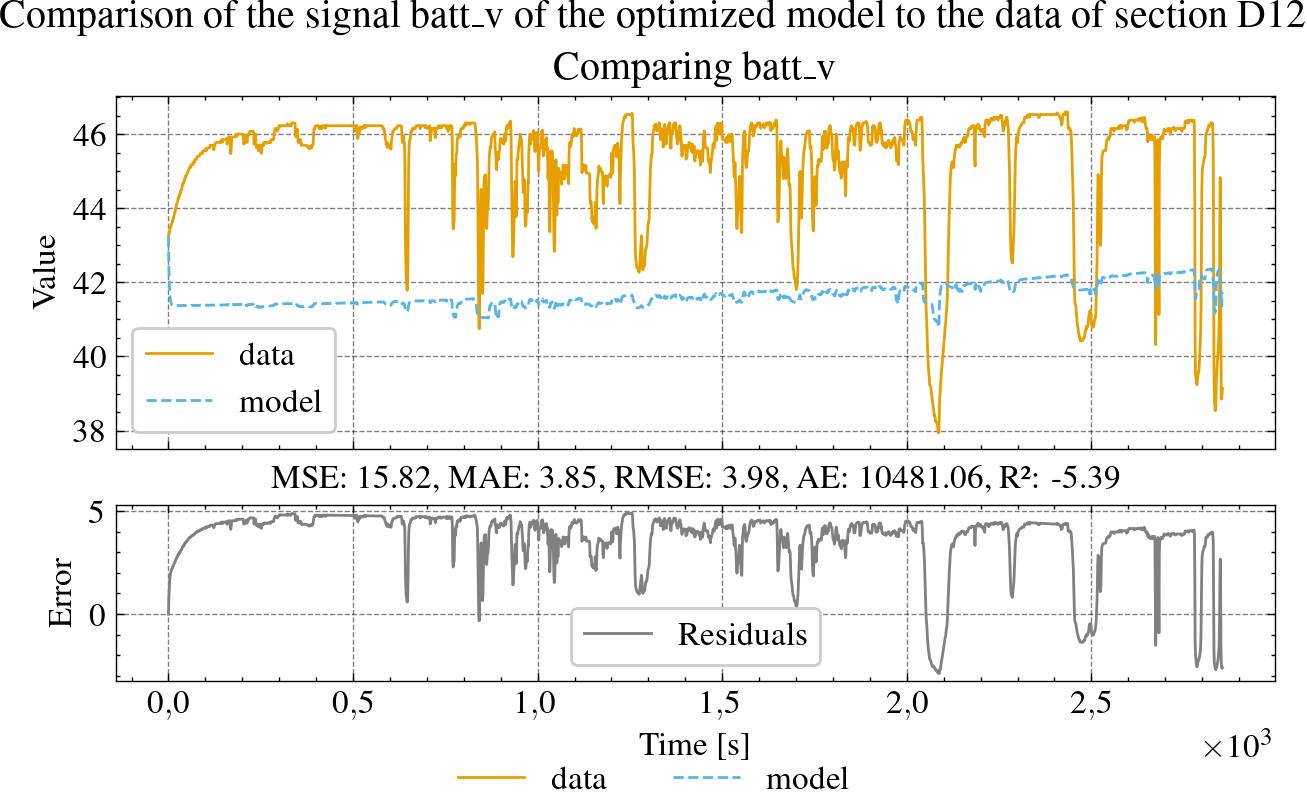

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d24.pdf


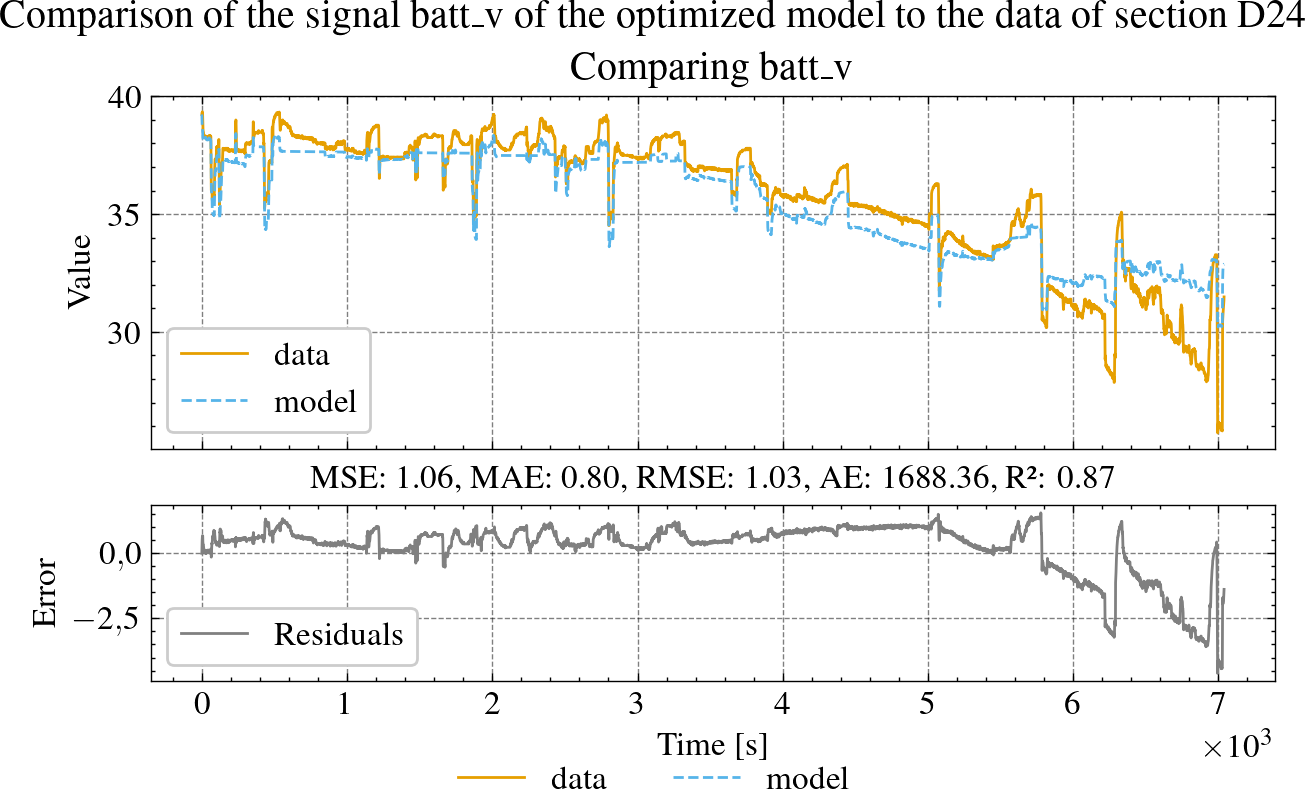

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d23.pdf


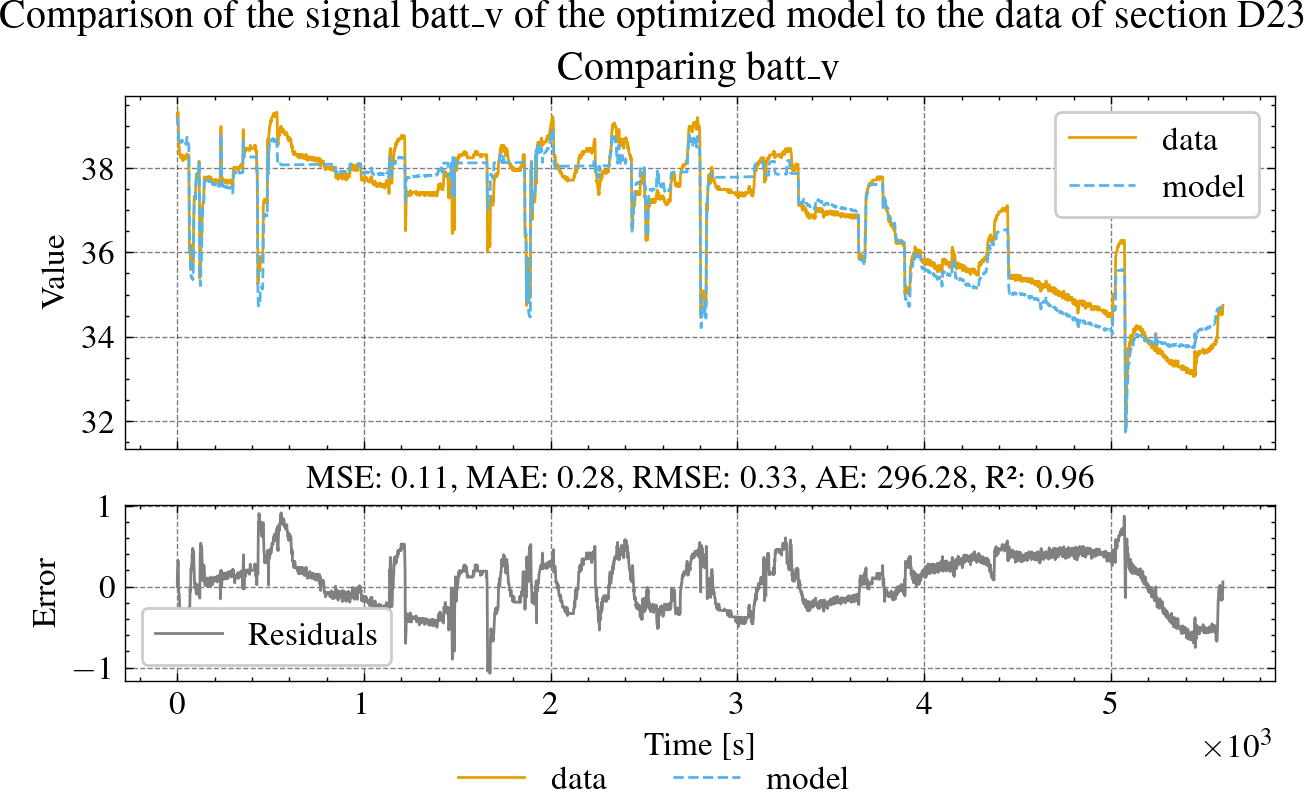

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d34.pdf


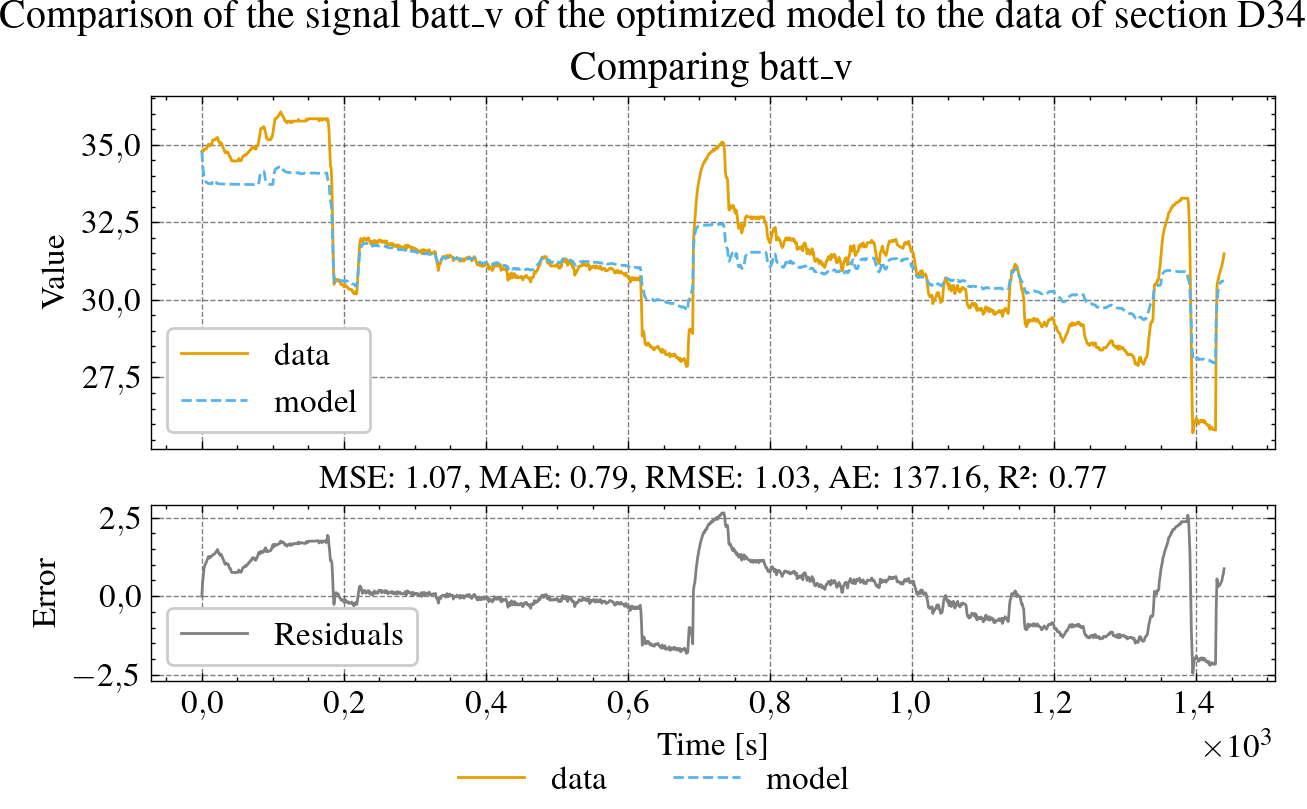

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d46.pdf


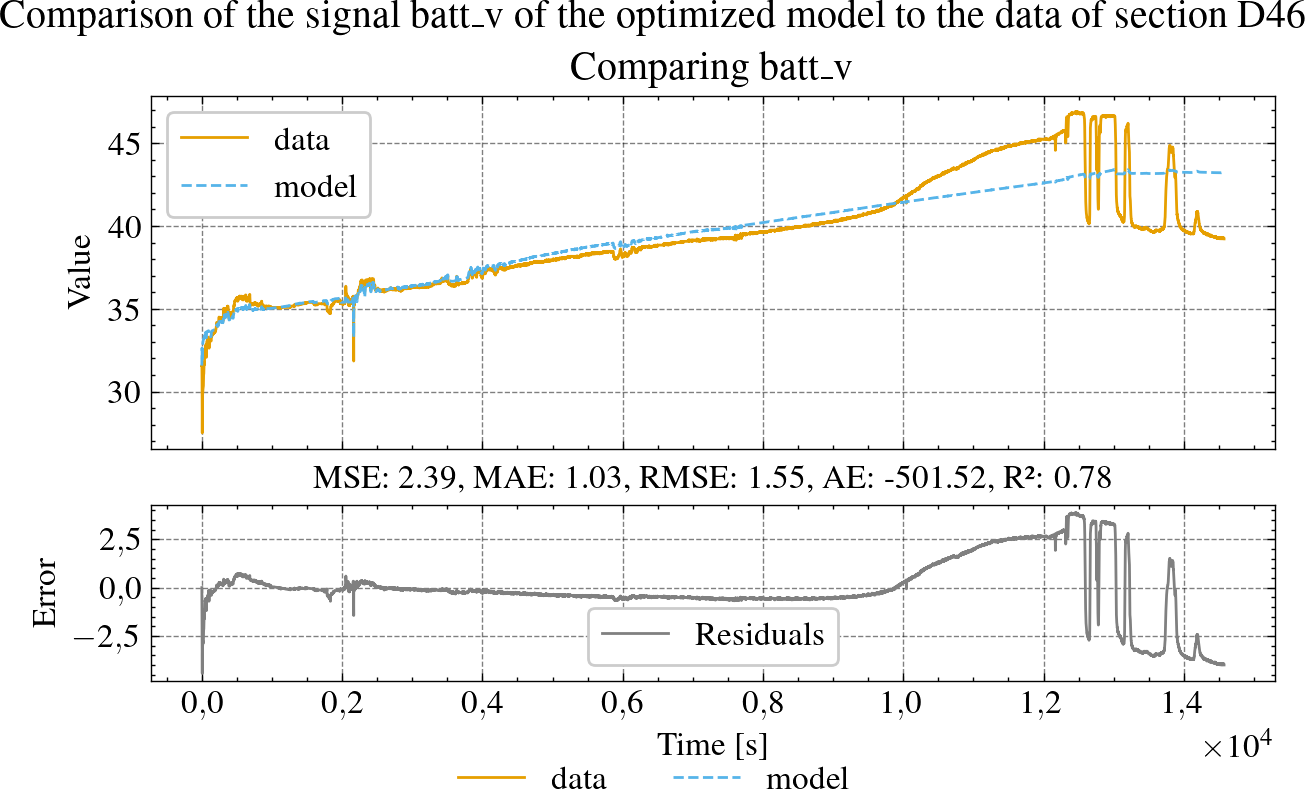

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d45.pdf


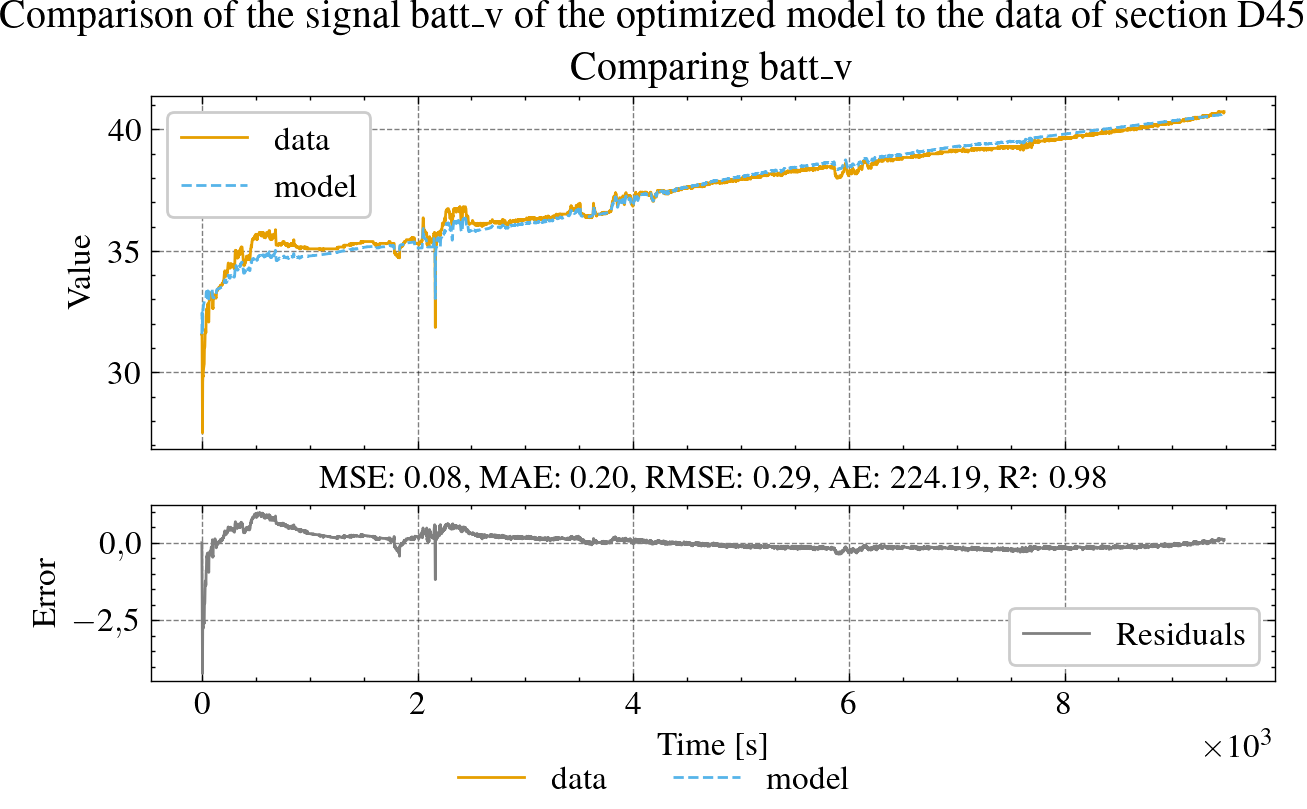

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d56.pdf


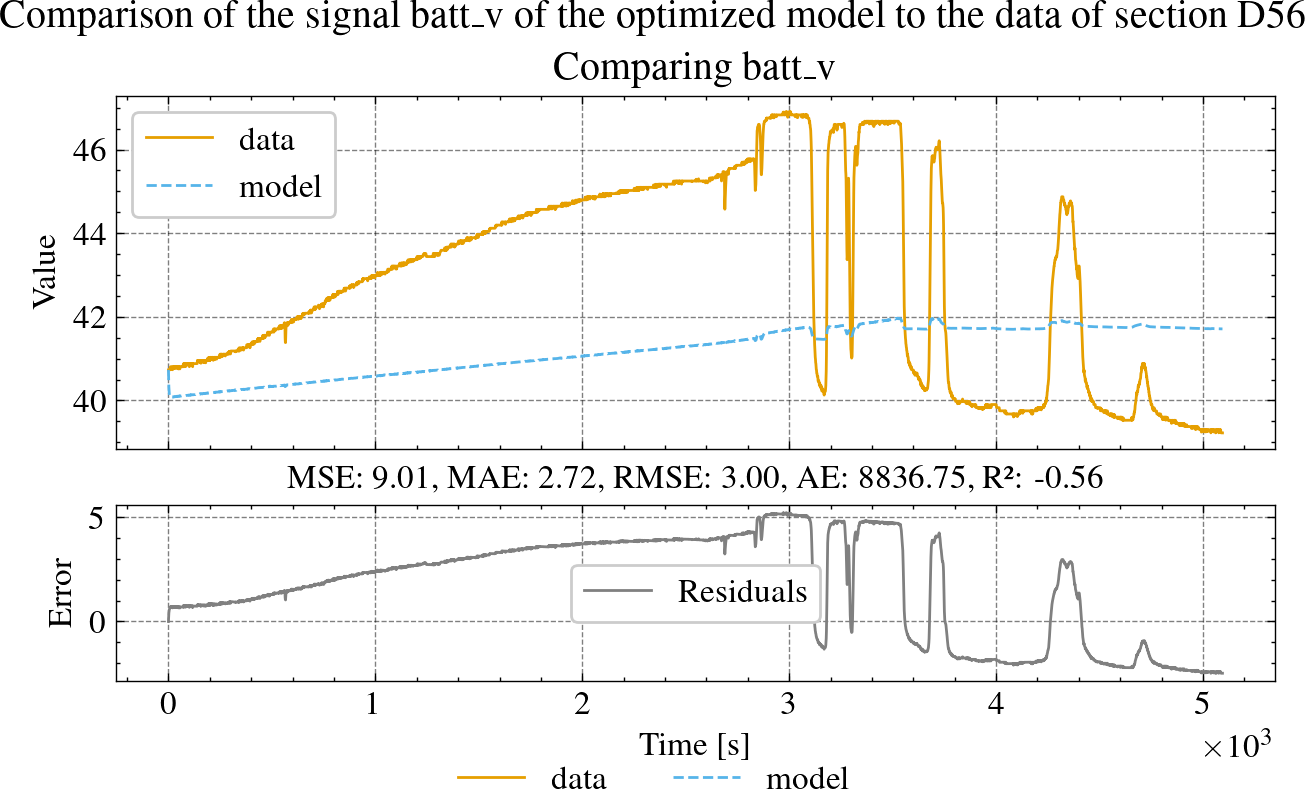

KeyError: 'E'

In [29]:
print(batt_z_0_dict)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')
    batt_z_0 = batt_z_0_dict[section_name]

    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_section.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue
    compute_df_capacity(df_section, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_section, nominal_Q, inplace=True)

    T = np.ascontiguousarray(df_section['t'].to_numpy())
    U = np.ascontiguousarray(df_section[input_cols].to_numpy().T)
    X0 = Battery.initial_state(
        X0={
            'batt_z': df_section['batt_z'][0],
            'batt_v': df_section['batt_v'][0],
        },
        U0=U[:, 0],
        params=model_params | best_params
    )

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_section, df_pred, col, show=False),
        )
